In [1]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.types import Command
from typing import Literal
from langgraph.graph import MessagesState, END
from langchain_core.tools import tool

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

### Define Tools

In [4]:
import re
from urllib.parse import urlparse

from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )


@tool
def is_valid_url(url: str) -> str:
    """Use to validate that the input URL is able for processing"""
    if not url:  # Check for empty string
        return False

    # Regex Check (Quick initial filter)
    regex = r"^(?:http(s)?:\/\/)?[\w.-]+(?:\.[\w\.-]+)+[\w\-\._~:/?#[\]@!\$&'\(\)\*\+,;=.]+$"
    if not re.match(regex, url):
        return 'Invalid URL'

    try:
        parsed_url = urlparse(url)

        # Check if scheme contains http/https
        if not parsed_url.scheme:
          return 'Invalid URL'

        # Check if network location is present
        if not parsed_url.netloc:
            return 'Invalid URL'
        
        return 'Valid URL'

    except Exception:
        return 'Invalid URL'
    

def get_next_node(last_message: BaseMessage, goto: str):
    if "Invalid URL" in last_message.content or "invalid URL" in last_message.content:
        return END
    return goto

def get_next_node_based_on_text_existence(last_message: BaseMessage, goto: str):
    if len(last_message.content) <= 100:
        return END
    return goto

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Helper Functions

In [5]:
from langchain_core.language_models.chat_models import BaseChatModel
from typing_extensions import TypedDict

class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

### Input Validation Team

In [6]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)


''' Input Agent '''
input_agent = create_react_agent(
    llm, 
    tools=[is_valid_url],
    prompt=(
        "You are only in charge of validating the URL, do not modify the URL in any way."
        "If you identify that the URL is invalid, please stop by Invalid URL identification."
    )
)

def input_node(state: MessagesState) -> Command[Literal["web_scraper", END]]:
    result = input_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "web_scraper")
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="input")
            ]
        },
        goto=goto,
    )


''' Web Scraper Agent '''
web_scraper_agent = create_react_agent(
    llm, 
    tools=[scrape_webpages],
)

def web_scraper_node(state: MessagesState) -> Command[Literal["content_formatting", END]]:
    result = web_scraper_agent.invoke(state)
    goto = get_next_node_based_on_text_existence(result["messages"][-1], "content_formatting")
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        goto=goto,
    )


''' Content Formatting Agent '''
content_formatting_agent = create_react_agent(
    llm,
    tools=[],
    prompt=(
        "You are an agent tasked to improve the formatting of the content scraped from the a web page."
        "Structure the extracted content into a readable format."
        "Organize the text using headings, bullet points, or summary sections."
        "Normalize and removes unwanted characters or redundant data."
    )
)

def content_formatting_node(state: MessagesState) -> Command[Literal[END]]:
    result = content_formatting_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="content_formatting")
            ]
        },
        goto=END,
    )

In [7]:
from langgraph.graph import StateGraph, START

workflow_preprocessing = StateGraph(MessagesState)
workflow_preprocessing.add_node("input", input_node)
workflow_preprocessing.add_node("web_scraper", web_scraper_node)
workflow_preprocessing.add_node("content_formatting", content_formatting_node)

workflow_preprocessing.add_edge(START, "input")
preprocessing_graph = workflow_preprocessing.compile()

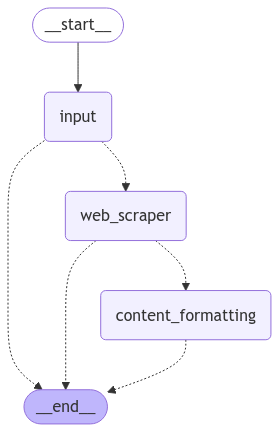

In [8]:
from IPython.display import Image, display

try:
    display(Image(preprocessing_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
events = preprocessing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Scrap the following URL: https://es.wikipedia.org/wiki/Ecuador",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("-----------------------------------")

{'input': {'messages': [HumanMessage(content='The URL "https://es.wikipedia.org/wiki/Ecuador" is valid for processing.', additional_kwargs={}, response_metadata={}, name='input', id='094dfe82-eaf4-45f0-883c-6c17f55e592e')]}}
-----------------------------------
{'web_scraper': {'messages': [HumanMessage(content='He extraído la información de la página de Wikipedia sobre Ecuador. Aquí tienes un resumen de los principales temas cubiertos en el artículo:\n\n1. **Toponimia**: El nombre "Ecuador" hace referencia a la línea ecuatorial que atraviesa el país.\n\n2. **Historia**: \n   - **Era prehispánica**: Incluye culturas como la Valdivia, una de las más antiguas en América.\n   - **Época Virreinal**: Conquista española y establecimiento de la Real Audiencia de Quito.\n   - **Independencia y Gran Colombia**: Proceso de independencia de España y posterior unión a la Gran Colombia.\n   - **Primer siglo de la República**: Incluye la dominación floreana y la Revolución Liberal.\n   - **Velasquism

### Text Analyzer

In [10]:
llm = ChatOpenAI(model="gpt-4o")

analizer_agent = create_react_agent(
    llm,
    tools=[],
    prompt=(
        "Improve the following text by considering"
        "cross-references information to identify biases, missing perspectives, or additional context."
        "Ask for help if there is any information that you need to clarify."
    ),
)

def analyzer_node(state: State) -> Command[Literal["supervisor"]]:
    result = analizer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="analyzer")
            ]
        },
        goto="supervisor",
    )


research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=(
        "You are a researcher tasked with finding additional information on the topic."
    ),
)

def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


summarizer_agent = create_react_agent(
    llm, 
    tools=[],
    prompt=(
        "You are a summarizer agent in charge of generating a structured analyticasl report based on key findings."
    )
)

def summarizer_node(state: State) -> Command[Literal["supervisor"]]:
    result = summarizer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="summarizer"
                )
            ]
        },
        goto="supervisor",
    )


doc_analyzer_node = make_supervisor_node(
    llm, ["analyzer", "researcher", "summarizer"]
)

In [11]:
# Create the graph here
analyzer_builder = StateGraph(State)
analyzer_builder.add_node("supervisor", doc_analyzer_node)
analyzer_builder.add_node("analyzer", analyzer_node)
analyzer_builder.add_node("researcher", research_node)
analyzer_builder.add_node("summarizer", summarizer_node)

analyzer_builder.add_edge(START, "supervisor")
analyzer_graph = analyzer_builder.compile()

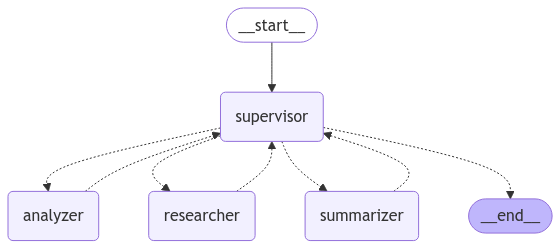

In [12]:
from IPython.display import Image, display

display(Image(analyzer_graph.get_graph().draw_mermaid_png()))

In [13]:
for s in analyzer_graph.stream(
    {
        "messages": [
            (
                "user",
                "Analiza el siguiente texto: 1. **Toponimia**: El nombre Ecuador hace referencia a la línea ecuatorial que atraviesa el país. 2. **Historia**: Se detalla la era prehispánica, la época virreinal, la independencia y la formación de la Gran Colombia, así como el desarrollo de la República de Ecuador a lo largo de los siglos XIX y XX. 3. **Estado y política**: Ecuador es una república presidencialista con un sistema de gobierno descentralizado. Se describen las funciones ejecutiva, legislativa, judicial, electoral y de transparencia y control social.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'analyzer'}}
---
{'analyzer': {'messages': [HumanMessage(content='El texto proporciona un resumen conciso sobre diferentes aspectos de Ecuador, pero existen oportunidades para enriquecer su análisis mediante la inclusión de información adicional y la consideración de posibles sesgos.\n\n1. **Toponimia**: La explicación del nombre "Ecuador" es simple y correcta, haciendo referencia a su ubicación geográfica respecto a la línea del ecuador. Sin embargo, sería pertinente mencionar cualquier influencia cultural o histórica adicional que pueda haber tenido en la elección del nombre.\n\n2. **Historia**: Se identifican períodos importantes en la historia de Ecuador, pero el típico enfoque en periodos grandes podría omitir detalles sobre grupos indígenas y su impacto cultural, social y político en años recientes. Además, al hablar del desarrollo de la República, convendría examinar eventos claves como la Revolución Liberal y su influencia en las reformas agrarias y educ

### Add Layers

In [14]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

def call_preprocessing_team(state: State) -> Command[Literal["analyzer_team"]]:
    response = preprocessing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="preprocessing_team"
                )
            ]
        },
        goto="analyzer_team",
    )


def call_analyzing_team(state: State) -> Command[Literal[END]]:
    response = analyzer_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="analyzing_team"
                )
            ]
        },
        goto=END,
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("preprocessing_team", call_preprocessing_team)
super_builder.add_node("analyzer_team", call_analyzing_team)

super_builder.add_edge(START, "preprocessing_team")
super_graph = super_builder.compile()

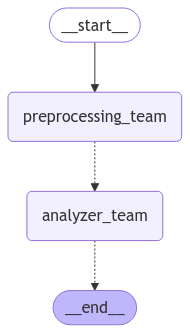

In [15]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [16]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Scrap the following URL: https://es.wikipedia.org/wiki/Ecuador",)
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'preprocessing_team': {'messages': [HumanMessage(content='# Resumen de Ecuador\n\n## 1. Toponimia\n- El nombre "Ecuador" se refiere a la línea ecuatorial que atraviesa el país.\n\n## 2. Historia\n- **Era prehispánica**: Incluye culturas como la Valdivia, una de las más antiguas en América.\n- **Época Virreinal**: Conquista española y establecimiento de la Real Audiencia de Quito.\n- **Independencia y Gran Colombia**: Proceso de independencia de España y posterior unión a la Gran Colombia.\n- **Primer siglo de la República**: Incluye la dominación floreana y la Revolución Liberal.\n- **Velasquismo y gobiernos militares**: Periodo de inestabilidad política y dictaduras militares.\n- **Historia contemporánea**: Desde el retorno a la democracia en 1979 hasta la actualidad.\n\n## 3. Estado y Política\n- Ecuador es una república presidencialista.\n- Cuenta con cinco funciones estatales: Ejecutiva, Legislativa, Judicial, Electoral, y de Transparencia y Control Social.\n\n## 4. Organización T